In [0]:
import numpy as np
#We'll make it reproducible by using this seed
np.random.seed(1)
import torch
import torch.optim as optim
torch.manual_seed(1)
import torch.nn as nn
import torch.nn.functional as F
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(1)
from torchvision import datasets, transforms
import matplotlib

import matplotlib.pyplot as plt

import pickle
import os
# Let's define some hyper-parameters that will be changed
hparams = {
    'batch_size':64,
    'num_epochs':20,
    'val_batch_size':64,
    'test_batch_size':64,
    'hidden_size':128,
    'num_classes':10,
    'num_inputs':784,
    'learning_rate':1e-3,
    'log_interval':100,
}

mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))
mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))

length_train = len(mnist_trainset)

#Split the training into validation and training
train_dataset, validation_dataset = torch.utils.data.random_split(mnist_trainset, [int(0.95*length_train), int(0.05*length_train)])


# The argument "drop_last=True" is given in order to ensure that there won't be a last batch that is not full
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=hparams['batch_size'], 
    shuffle=True,drop_last=True) #Probar si peta sin el drop_last pero no es prioritario

val_loader = torch.utils.data.DataLoader(validation_dataset,
                                         batch_size=hparams['val_batch_size'], 
                                         shuffle=True,drop_last=False)

test_loader = torch.utils.data.DataLoader(
    mnist_testset,
    batch_size=hparams['test_batch_size'], 
    shuffle=False,drop_last=False)


class Encoder(nn.Module):
   ''' 
   This the encoder part of CAE
   '''

   def __init__(self, bottleneck_size):
     super().__init__()

     self.conv1 = nn.Conv2d(1,16,3,padding=1)
     self.pool  = nn.MaxPool2d(2,2)
     self.conv2 = nn.Conv2d(16,4,3,padding=1)
     self.bottleneck_layer = nn.Linear(4 * 7 * 7, bottleneck_size)


   def forward(self,x):
      ## encode ##
      # add hidden layers with relu activation function
      # and maxpooling after
      x = F.relu(self.conv1(x))
      x = self.pool(x)
      # add second hidden layer
      x = F.relu(self.conv2(x))
      x = self.pool(x)  # compressed representation
      x = x.view(-1, 4 * 7 * 7)
      x = self.bottleneck_layer(x)

      return x

class Decoder(nn.Module):
   ''' 
   This the decoder part of CAE
   '''

   def __init__(self, bottleneck_size, bottleneck_layer = None):
     super().__init__()

     ## decoder layers ##
     ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
     self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
     self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)
     self.bottleneck_reconstruct = nn.Linear(bottleneck_size, 4*7*7)

   def forward(self,x):
     ## decode ##
     # add transpose conv layers, with relu activation function
     x = self.bottleneck_reconstruct(x)
     x = x.view(-1, 4, 7, 7)

     x = F.relu(self.t_conv1(x))
     # output layer (with sigmoid for scaling from 0 to 1)
     x = F.sigmoid(self.t_conv2(x))
            
     return x

class CAE(nn.Module):
  '''
  This takes both encoder and decoder into the same network
  '''

  def __init__(self, enc, dec):
    super().__init__()

    self.encoder = enc
    self.decoder = dec

  def forward(self,x):
    #encode
    x = self.encoder(x)
    #Decode
    predicted = self.decoder(x)

    return predicted



def train(model, num_epochs):
  # Prepare the GPU and the model to start training
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  # First thing is first, specify loss function and optimizer criterion
  # The professor said we should used Mean Square Error
  # From the slides, ADAM was the best optimizer thus:
  costFunc = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr = hparams['learning_rate']) # learning rate chosen at random
  
  trainLoss =[]
  validationLoss =[]
  
  for epoch in range(num_epochs):
    # We should track the loss of the model
    closs = 0
    valloss=0
    # total = 0
    model.train()
    for batch_idx, (data,_) in enumerate(train_loader):
      # Put data and label into GPU
      # model.train()
      data = data.to(device)
      # What does the model say? Pix pix pix pix pix pix pix pix
      prediction = model(data)
      # Compute loss
      loss = costFunc(prediction,data)
      # Save loss to plot it later
      closs += loss.item()*data.size(0) #this data.size(0) is the train_batch_size
      # Careful with the drop_last

      # Name a more iconic trio
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch,closs/len(train_loader)))
    trainLoss.append(closs/len(train_loader))
    
    # Let's check accuracy with our validation set
  #  correctHits = 0
    model.eval()
    for index,(data,_)  in enumerate(val_loader):
        data = data.to(device)
        prediction = model(data)
        loss = costFunc(prediction,data)
      # Save loss to plot it later
        valloss += loss.item()*data.size(0)
    validationLoss.append(valloss/len(val_loader))
  return {"trainLoss":trainLoss,"validationLoss":validationLoss}




In [0]:
bottleneckSizes = np.linspace(2,60,15,dtype=np.int32)
loss= []
models = []

for bottleneckSize in bottleneckSizes:
    encoder = Encoder(bottleneckSize)
    decoder = Decoder(bottleneckSize)
    model = CAE(encoder,decoder)
    modelloss=train(model,hparams["num_epochs"])
    loss.append(modelloss)
    models.append(model)
    print(modelloss)
    



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0 	Training Loss: 53.254554
Epoch: 1 	Training Loss: 50.068574
Epoch: 2 	Training Loss: 49.588808
Epoch: 3 	Training Loss: 48.732442
Epoch: 4 	Training Loss: 47.421226
Epoch: 5 	Training Loss: 47.089434
Epoch: 6 	Training Loss: 46.907315
Epoch: 7 	Training Loss: 46.748945
Epoch: 8 	Training Loss: 46.590074
Epoch: 9 	Training Loss: 46.481900
Epoch: 10 	Training Loss: 46.403624
Epoch: 11 	Training Loss: 46.332118
Epoch: 12 	Training Loss: 46.255155
Epoch: 13 	Training Loss: 46.171256
Epoch: 14 	Training Loss: 46.114926
Epoch: 15 	Training Loss: 46.074216
Epoch: 16 	Training Loss: 46.035759
Epoch: 17 	Training Loss: 46.009068
Epoch: 18 	Training Loss: 45.979373
Epoch: 19 	Training Loss: 45.943352
{'trainLoss': [53.25455365984627, 50.068573983867516, 49.58880802111679, 48.73244186144196, 47.42122560136774, 47.089433901497486, 46.90731536350893, 46.74894520620282, 46.59007433344809, 46.481899917259646, 46.40362425386236, 46.332117612174386, 46.2551547704118, 46.17125568604202, 46.114

In [0]:
with open('loss.pickle', 'wb') as f: pickle.dump(loss, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('models.pickle', 'wb') as f: pickle.dump(models, f, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:

with open(os.path.abspath("loss.pickle"), 'rb') as handle:
    loss = pickle.load(handle)
with open(os.path.abspath("models.pickle"), 'rb') as handle:
    models = pickle.load(handle)

bottleneckSizes = np.linspace(2,60,15,dtype=np.int32)

In [0]:
trainlosses = [los["trainLoss"] for los in loss]
vallosses = [los["validationLoss"] for los in loss]

Text(0.5, 1.0, 'Training MSE for different bottlenecks')

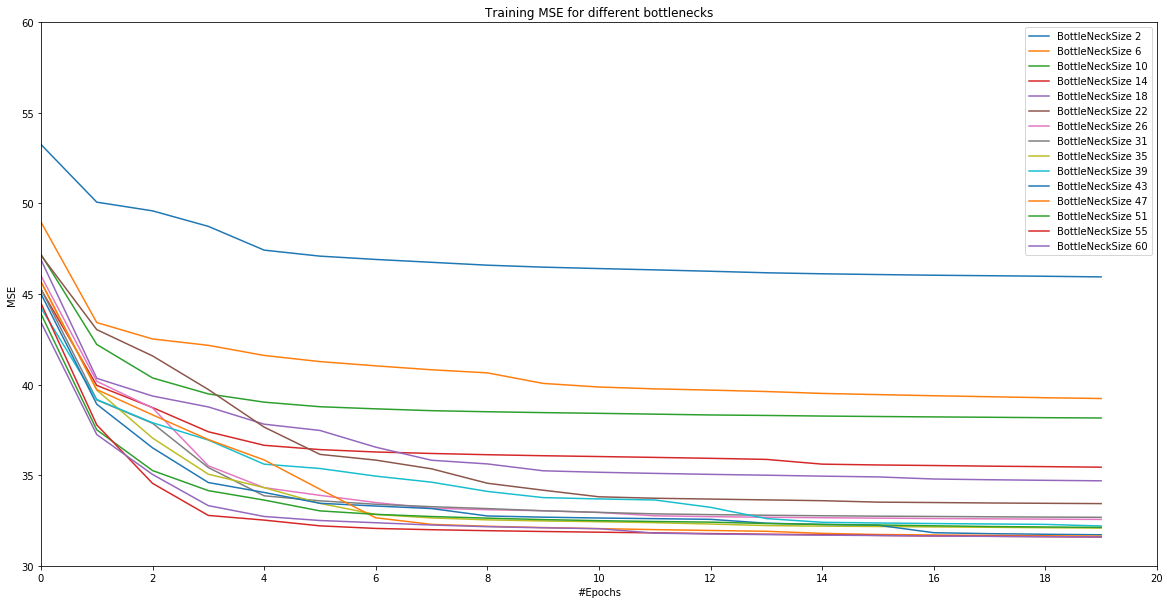

In [0]:
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)
ax.axis([0 ,20,30,60 ])
ax.plot(range(hparams["num_epochs"]),np.array(trainlosses).T)
ax.legend([ f"BottleNeckSize {bottleneckSize}" for bottleneckSize in bottleneckSizes])
ax.set_xlabel('#Epochs')
ax.set_ylabel('MSE')
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.set_title('Training MSE for different bottlenecks')

Text(0.5, 1.0, 'Validation MSE for different bottlenecks')

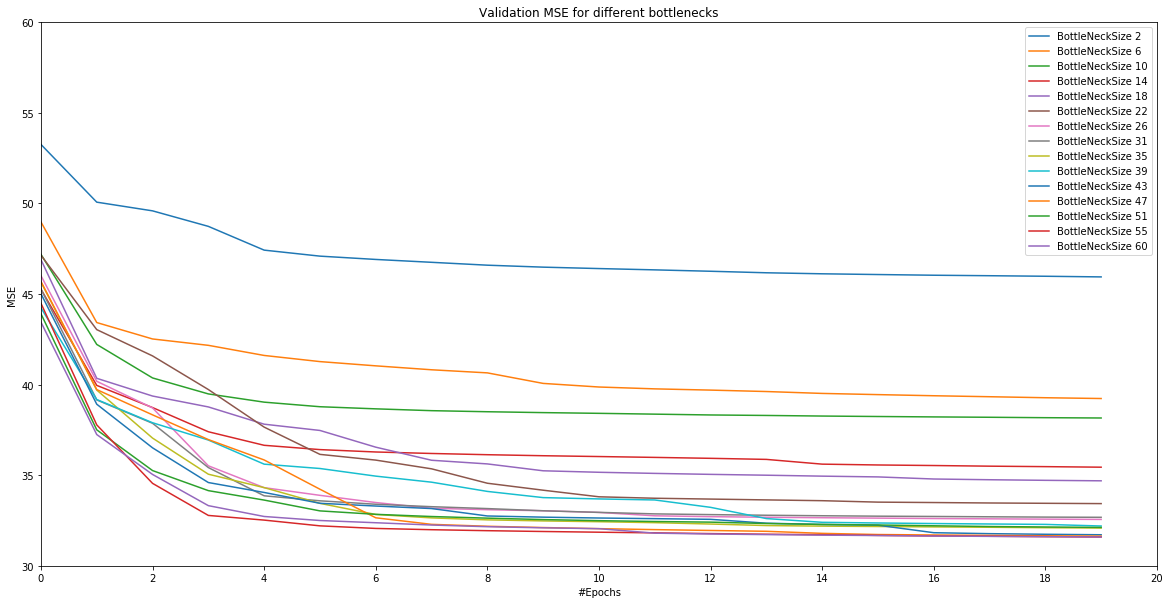

In [0]:
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)
ax.axis([0 ,20,30,60 ])

ax.plot(range(hparams["num_epochs"]),np.array(trainlosses).T)
ax.legend([ f"BottleNeckSize {bottleneckSize}" for bottleneckSize in bottleneckSizes])
ax.set_xlabel('#Epochs')
ax.set_ylabel('MSE')
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.set_title('Validation MSE for different bottlenecks')

In [0]:
model = models[2]
mean = 0.
std = 0.
model.eval()
model.to("cpu")
encodedimages = model.encoder(list(train_loader))
for images, _ in encodedimages:
   
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    

mean /= len(encodedimages)
std /= len(encodedimages)
bottleneckSize=115

print(mean)
print(std)


with torch.no_grad():

  rndnoise =torch.normal(mean=float(mean),std=float(std),size=(20,1,4*7*7,bottleneckSize))
  genimages = model.decoder(rndnoise)

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip(genimages, axes):
  for img, ax in zip(images, row):
      ax.imshow(np.squeeze(img), cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)










TypeError: ignored

In [0]:
len(list(model.decoder.parameters())[0])

4